# Labeling Approach via Autoencoder

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [2]:
path = "dataset"
n = "1"
colnames = ['id', 'dt',
            'set1', 'set2', 'set3',
            's1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 
            's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19', 's20', 's21']

In [3]:
train = pd.read_table(f"{path}/train_FD00{n}.txt", header=None, delim_whitespace=True)
test = pd.read_table(f"{path}/test_FD00{n}.txt", header=None, delim_whitespace=True)
rul = pd.read_table(f"{path}/RUL_FD00{n}.txt", header=None, delim_whitespace=True)

train.columns = colnames
test.columns = colnames
rul.columns = ["rul"]

In [6]:
train

,id,dt,set1,set2,set3,s1,s2,s3,s4,s5,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.0004,-0.0003,100.0,518.67,643.49,1597.98,1428.63,14.62,...,519.49,2388.26,8137.60,8.4956,0.03,397,2388,100.0,38.49,22.9735
20627,100,197,-0.0016,-0.0005,100.0,518.67,643.54,1604.50,1433.58,14.62,...,519.68,2388.22,8136.50,8.5139,0.03,395,2388,100.0,38.30,23.1594
20628,100,198,0.0004,0.0000,100.0,518.67,643.42,1602.46,1428.18,14.62,...,520.01,2388.24,8141.05,8.5646,0.03,398,2388,100.0,38.44,22.9333
20629,100,199,-0.0011,0.0003,100.0,518.67,643.23,1605.26,1426.53,14.62,...,519.67,2388.23,8139.29,8.5389,0.03,395,2388,100.0,38.29,23.0640


## Usual preprocessing

In [22]:
def cScale(df):
    scaler = StandardScaler()
    sensors = ['s2', 's3', 's4', 's7', 's8', 's9', 's11', 's12', 's13', 's14', 's15', 's17', 's20', 's21']
    for c in ['c1', 'c2', 'c3', 'c4', 'c5', 'c6']:
        if 1 in data[c].to_list():
            scaler.fit(df.loc[df[c] == 1, sensors])
            df.loc[df[c] == 1, sensors] = scaler.transform(df.loc[df[c] == 1, sensors])
    return df

In [23]:
def exponential_smoothing(df,
                          sensors = ['s2', 's3', 's4', 's7', 's8', 's9', 's11', 's12', 's13', 's14', 's15', 's17', 's20', 's21'],
                          alpha = 0.4):
    df = df.copy()
    # first, calculate the exponential weighted mean of desired sensors
    df[sensors] = df.groupby('id')[sensors].apply(lambda x: x.ewm(alpha=alpha).mean())
    return df

In [82]:
data = train.copy()

In [83]:
settings = data[['set1', 'set2', 'set3']].copy()
settings['set1'] = settings['set1'].round()
settings['set2'] = settings['set2'].round(decimals=2)

data['c1'] = 0; data['c2'] = 0; data['c3'] = 0 ;data['c4'] = 0; data['c5'] = 0; data['c6'] = 0

c = 0
for i, d in settings.groupby(by = ['set1','set2','set3']):
    c += 1
    data.loc[d.index,['c' + str(c)]] = 1

In [84]:
data = data.drop(columns = ['s1', 's5', 's6', 's10', 's16', 's18', 's19'])
data = data.drop(columns = ['set1', 'set2', 'set3'])    
data = cScale(data)
data = exponential_smoothing(data)

## First 25% of Data Normal Operation, i.e. Data for Autoencoder Training

In [85]:
X25 = data.copy()
X25 = X25.drop(columns = ['c1', 'c2', 'c3', 'c4', 'c5', 'c6'])
for i, d in X25.groupby('id'):
    q25 = int(d.shape[0] / 4) + 1
    X25 = X25.drop(range(d.index[0] + q25, d.index[-1] + 1))
X25 = X25.drop(columns = ['id', 'dt'])

In [86]:
X25.head()

,s2,s3,s4,s7,s8,s9,s11,s12,s13,s14,s15,s17,s20,s21
0,-1.721725,-0.134255,-0.925936,1.121141,-0.516338,-0.862813,-0.266467,0.334262,-1.058890,-0.269071,-0.603816,-0.781710,1.348493,1.194427
1,-1.309259,0.081860,-0.749555,0.690384,-0.692435,-0.922816,-0.219664,0.859660,-0.624363,-0.502680,-0.398838,-0.781710,1.141015,1.220986
2,-0.978929,-0.170704,-0.635472,0.852512,-0.458837,-0.736246,-0.625603,1.117344,-0.775117,-0.527654,-0.526545,-1.440579,0.936360,0.854883
3,-0.833196,-0.671904,-0.704111,1.022694,-0.161556,-0.725943,-1.045587,1.505192,-0.522121,-0.524217,-1.190663,-1.137790,0.668087,0.819455
4,-0.741515,-0.923302,-0.529496,0.888976,-0.315434,-0.609321,-1.016213,1.309009,-0.634314,-0.523146,-0.821640,-0.703295,0.579245,0.923591


## Basic Autoencoder

In [87]:
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model

In [88]:
class Basic_Autoencoder(Model):
  def __init__(self, latent_dim, input_dim):
    super(Basic_Autoencoder, self).__init__()
    self.latent_dim = latent_dim   
    self.encoder = tf.keras.Sequential([
      layers.Dense(latent_dim, activation='relu'),
    ])
    self.decoder = tf.keras.Sequential([
      layers.Dense(input_dim, activation='sigmoid')
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

In [89]:
l_dim = 10
in_dim = X25.shape[1]

In [90]:
autoencoder = Basic_Autoencoder(latent_dim = l_dim, input_dim = in_dim)
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [91]:
autoencoder.fit(np.array(X25), np.array(X25),
                epochs = 10,
                shuffle = True,
                validation_split = 0.2)

Epoch 1/10
131/131 [==============================] - 0s 2ms/step - loss: 0.9169 - val_loss: 0.6709
Epoch 2/10
131/131 [==============================] - 0s 1ms/step - loss: 0.5867 - val_loss: 0.5329
Epoch 3/10
131/131 [==============================] - 0s 1ms/step - loss: 0.5180 - val_loss: 0.5017
Epoch 4/10
131/131 [==============================] - 0s 1ms/step - loss: 0.4899 - val_loss: 0.4886
Epoch 5/10
131/131 [==============================] - 0s 1ms/step - loss: 0.4785 - val_loss: 0.4834
Epoch 6/10
131/131 [==============================] - 0s 1ms/step - loss: 0.4738 - val_loss: 0.4811
Epoch 7/10
131/131 [==============================] - 0s 1ms/step - loss: 0.4715 - val_loss: 0.4795
Epoch 8/10
131/131 [==============================] - 0s 1ms/step - loss: 0.4700 - val_loss: 0.4784
Epoch 9/10
131/131 [==============================] - 0s 1ms/step - loss: 0.4688 - val_loss: 0.4774
Epoch 10/10
131/131 [==============================] - 0s 1ms/step - loss: 0.4679 - val_loss: 0.4765

In [92]:
x_test = np.array(data.drop(columns = ['id', 'dt', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6']))
prediction = autoencoder.predict(x_test)

In [96]:
from sklearn.metrics import mean_squared_error
reconstruction_error = []
for t in range(x_test.shape[0]):
        x = data.drop(columns = ['id', 'dt', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6']).iloc[t]
        x_hat = prediction[t]
        reconstruction_error.append(mean_squared_error(x, x_hat))

In [97]:
data['error'] = reconstruction_error

In [98]:
def pltsi(s, i, df):
    plt.figure(figsize=(15,5))
    for j in i:
        plt.plot('rul', s, data = df[df['id'] == j])  
    plt.xlim(300, 0)
    plt.xticks(np.arange(0, 300, 25))
    plt.ylabel(s)
    plt.xlabel('t')
    plt.show()

In [99]:
getRul = lambda col: col[::-1] - 1
rul_linear = data[['id', 'dt']].groupby('id').transform(getRul)
data['rul'] = rul_linear

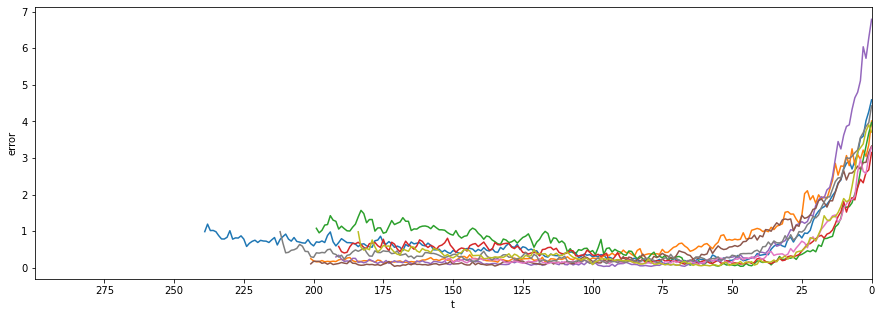

In [102]:
pltsi('error', [11,22,33,44,55,66,77,88,99], data)